In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
import statistics as stats

### Load image

(2287, 440, 3)

<Figure size 1440x2880 with 0 Axes>

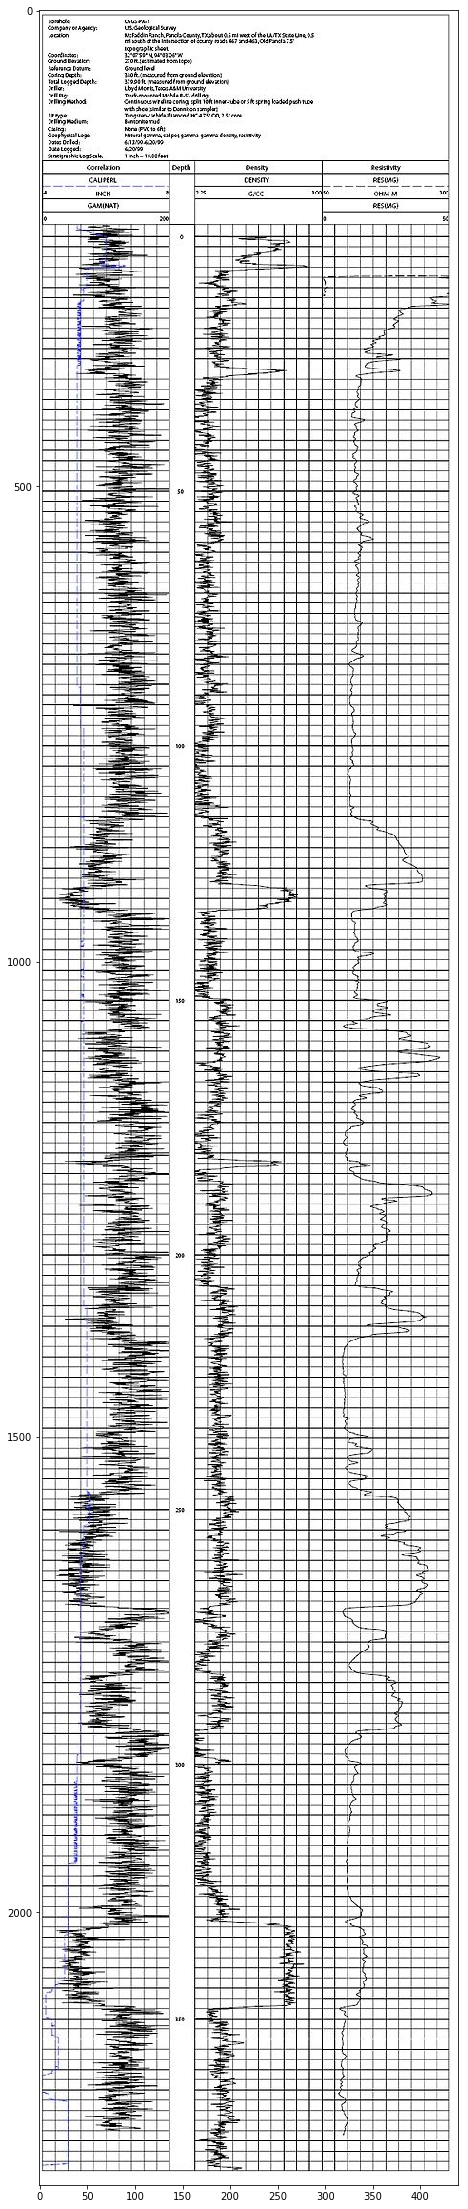

In [4]:
src = cv2.imread('../data/fieldprint.jpg'); src.shape
###
# OpenCV uses BGR as its default colour order for images, matplotlib uses RGB. 
# When you display an image loaded with OpenCv in matplotlib the channels will be back to front.
# The easiest way of fixing this is to use OpenCV to explicitly convert it back to RGB
###

plt.figure(figsize=(20,40))
_ = plt.imshow(src)

### BGR to Gray scale

In [5]:
# Transform source image to gray if it is not already
if len(src.shape) != 2:
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
else:
    gray = src

<Figure size 1440x2880 with 0 Axes>

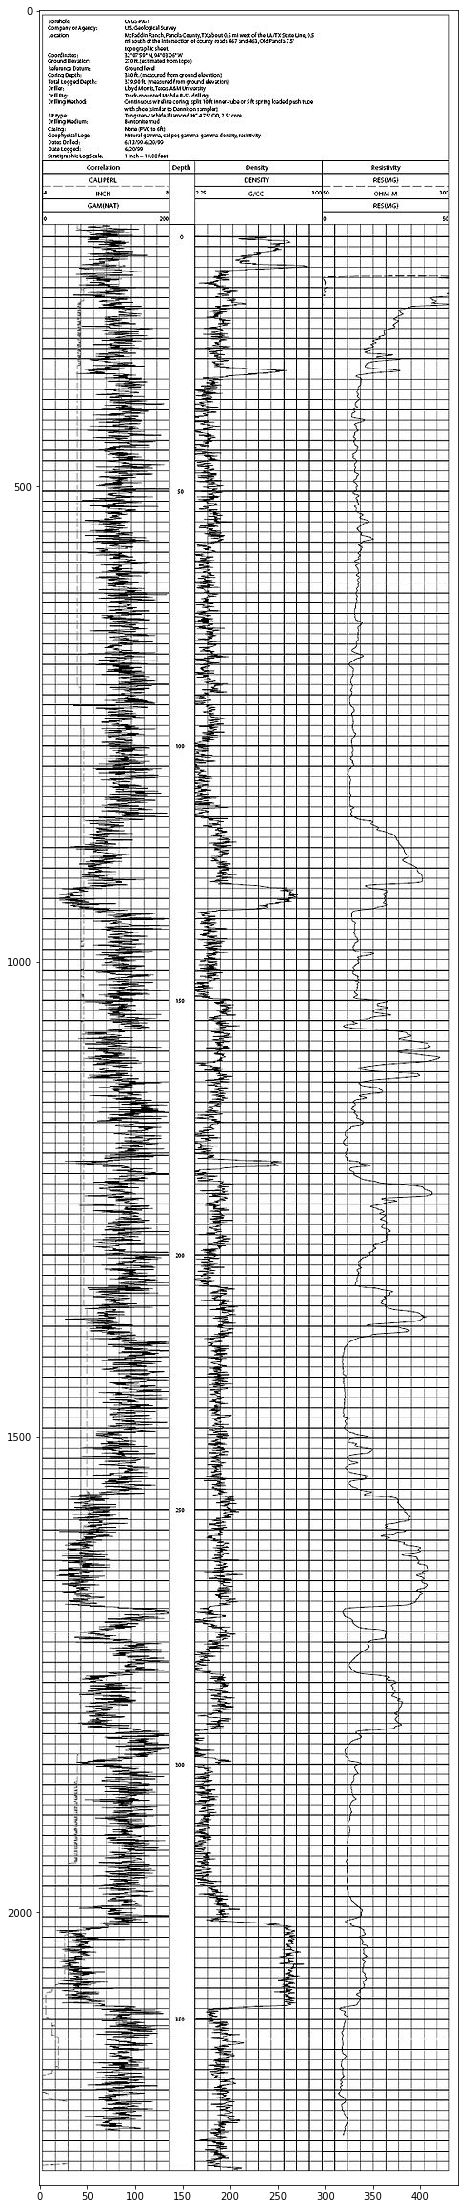

In [6]:
plt.figure(figsize=(20,40))
_ = plt.imshow(gray, cmap='gray')

### Gray scale to Binary

In [7]:
# Apply adaptiveThreshold at the bitwise_not of gray, notice the ~ symbol
gray = cv2.bitwise_not(gray)
bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)

<Figure size 1440x2880 with 0 Axes>

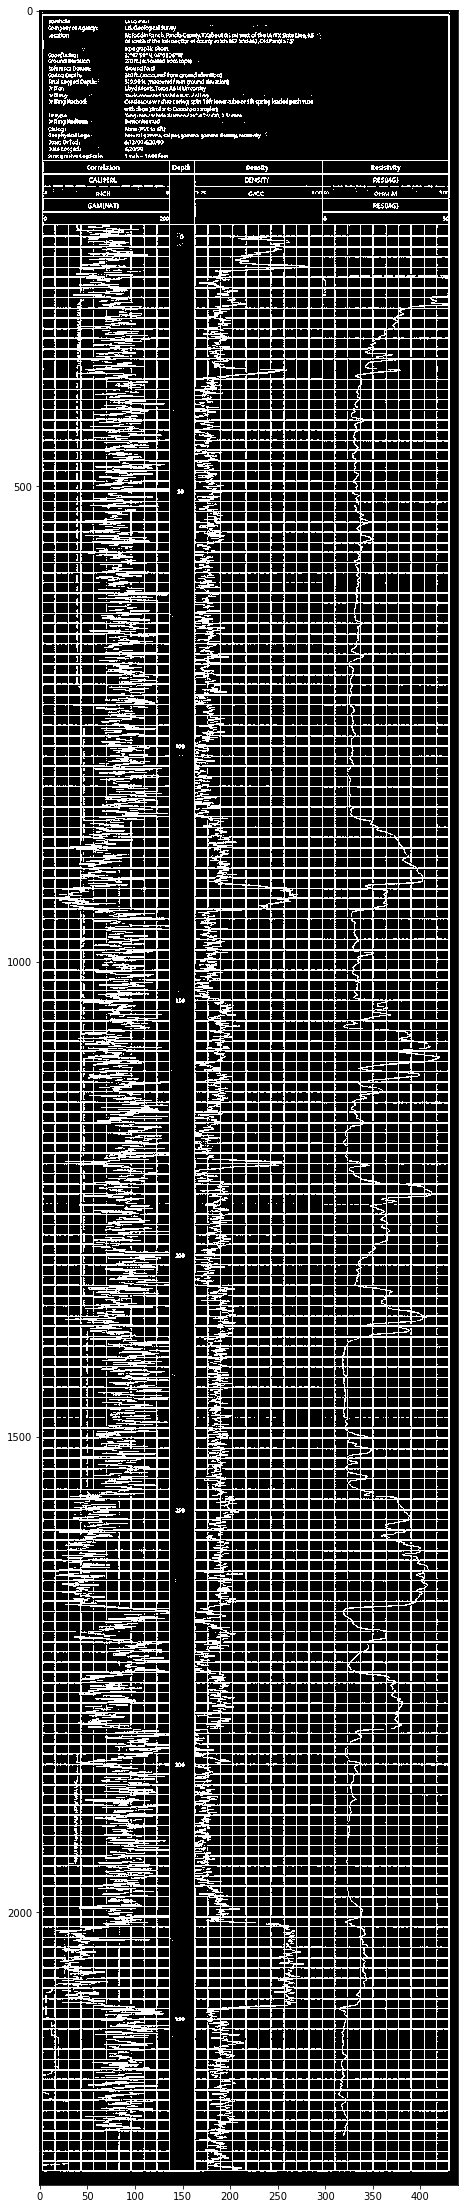

In [8]:
plt.figure(figsize=(20,40))
_ = plt.imshow(bw, cmap='gray')

### Histogram

In [9]:
bw.shape
vertSum = np.sum(bw,0)
horzSum = np.sum(bw,1)

(2287, 440)

<Figure size 1440x360 with 0 Axes>

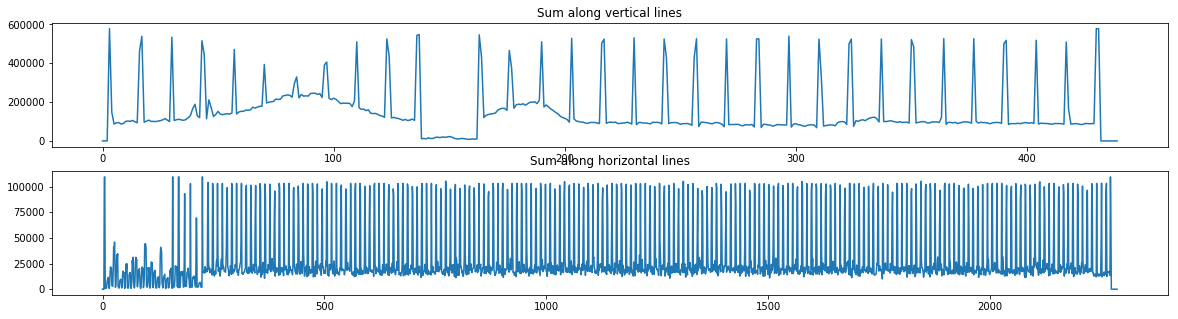

In [11]:
plt.figure(figsize=(20, 5))

_ = plt.subplot(2,1,1)
_ = plt.plot(vertSum)
_ = plt.title('Sum along vertical lines')

_ = plt.subplot(2,1,2)
_ = plt.plot(horzSum)
_ = plt.title('Sum along horizontal lines')

### By means of Histogram: vertical and horizontal lines

In [12]:
def interpolate(histogram, histoKeep_mask):

    histo_keep = histogram * histoKeep_mask; 
    histo_keep = histo_keep.astype('float')
    histo_keep[histo_keep==0] = np.nan; 
    
    not_nan = np.logical_not(np.isnan(histo_keep))
    indices = np.arange(len(histo_keep))
    histo_keep_interp = np.interp(indices, indices[not_nan], histo_keep[not_nan])
    
    return(histo_keep_interp)

In [13]:
def getMask(window_size, delta, histogram):
    
    histoMedian = np.zeros(0)

    for i in range(len(histogram)):
        histoMedian = np.append(histoMedian, stats.median(histogram[i:i+window_size])) # note the tail will be taking less than 10 elements

    histoKeep_mask = histogram <= (histoMedian + histoMedian*delta)
    
    histo_keep_interp = interpolate(histogram, histoKeep_mask)
    
    return(histo_keep_interp)

In [14]:
def removeLines(window_size, delta, histogram):
    histo_keep_interp = getMask(window_size, delta, histogram)
    histoKeepInterp_mask = histogram <= histo_keep_interp; 
    return(histoKeepInterp_mask)

In [21]:
window_size = 10
delta = 0.25
horzKeepInterp_mask = []
vertKeepInterp_mask = []

horzKeepInterp_mask = removeLines(window_size, delta, horzSum);
vertKeepInterp_mask = removeLines(window_size, delta, vertSum);


### Display

<Figure size 1440x2880 with 0 Axes>

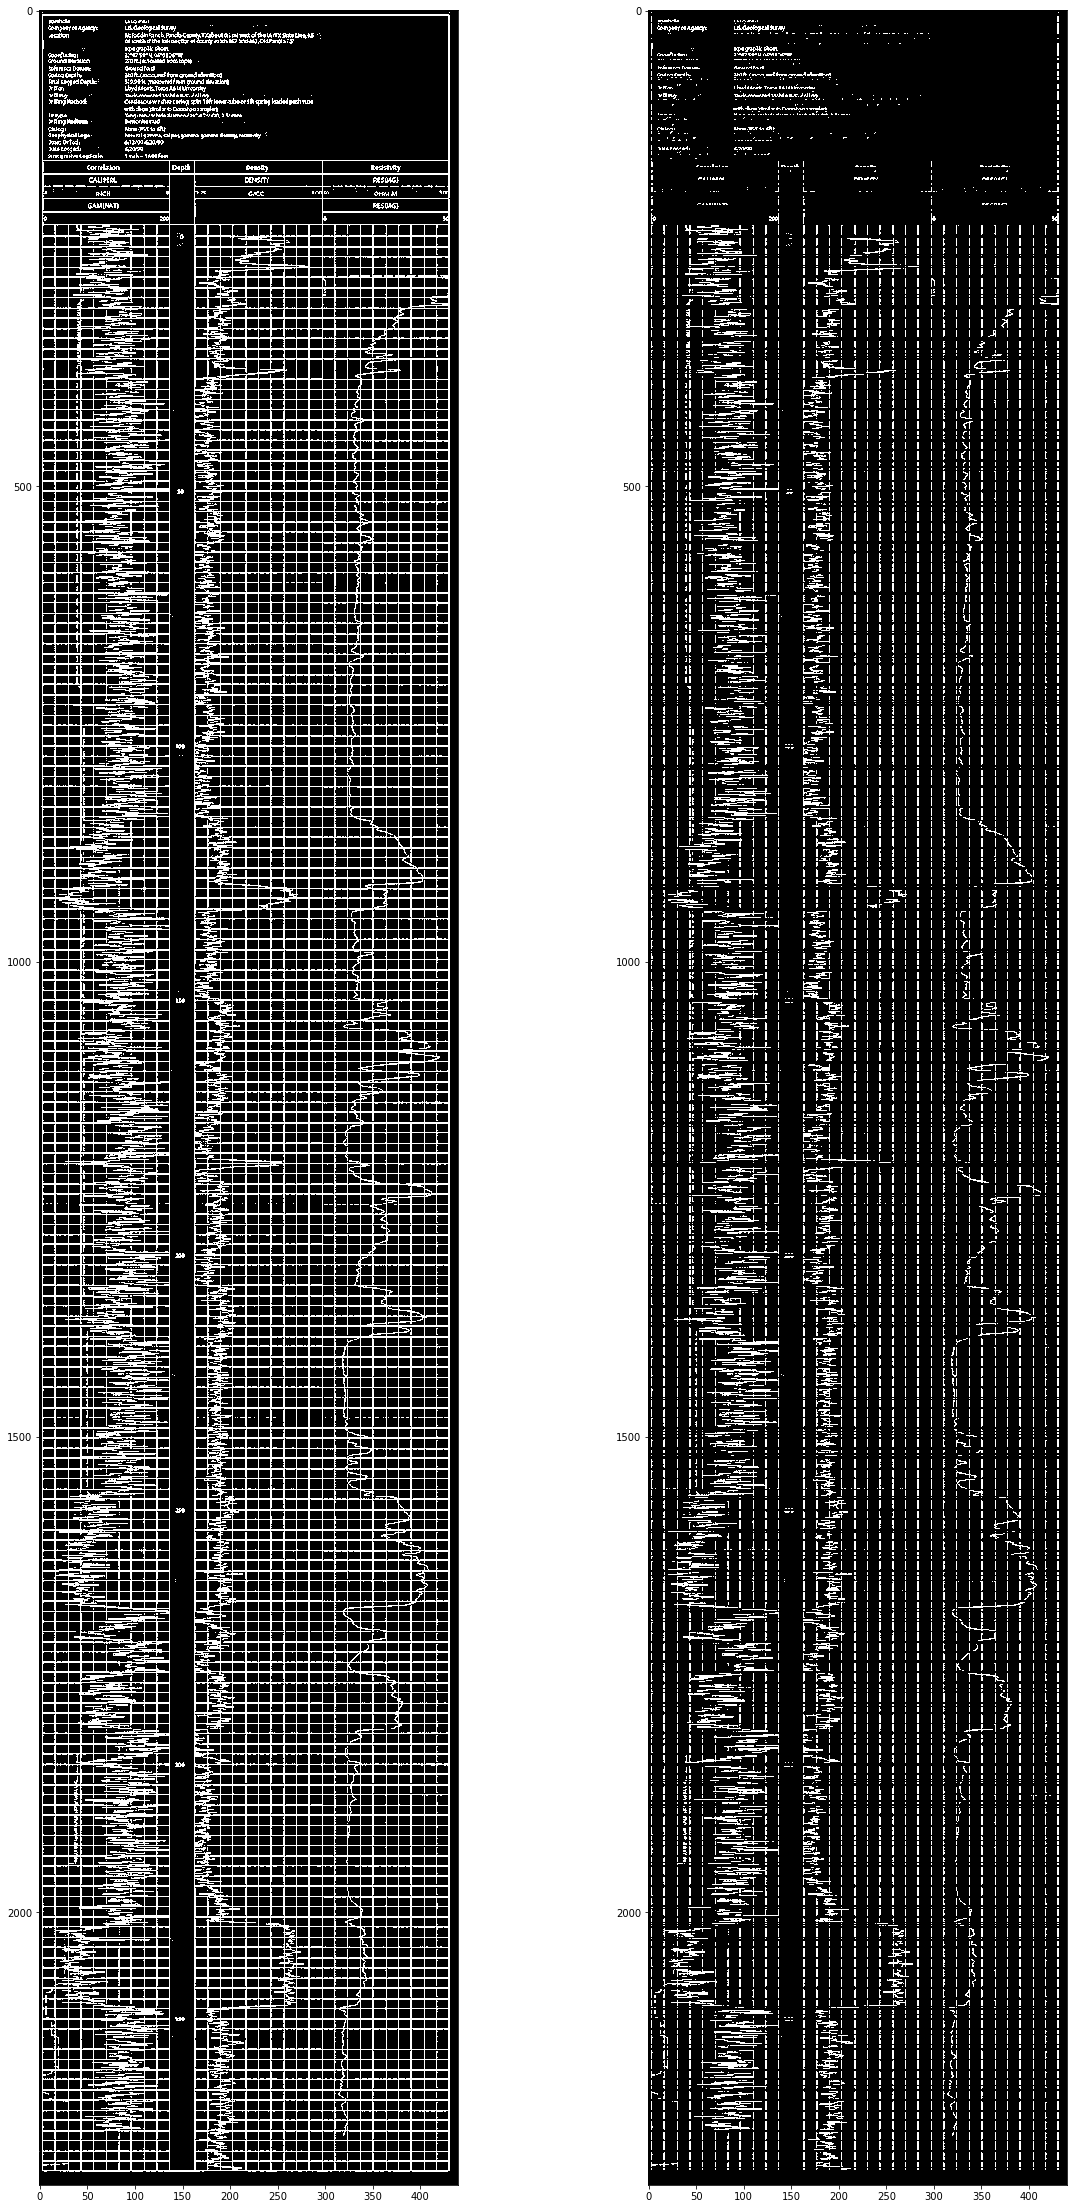

In [22]:
new2 = bw.T * horzKeepInterp_mask

plt.figure(figsize=(20,40))

_ = plt.subplot(1,2,1)
_ = plt.imshow(bw, cmap='gray')

_ = plt.subplot(1,2,2)
_ = plt.imshow(new2.T, cmap='gray')

<Figure size 1440x2880 with 0 Axes>

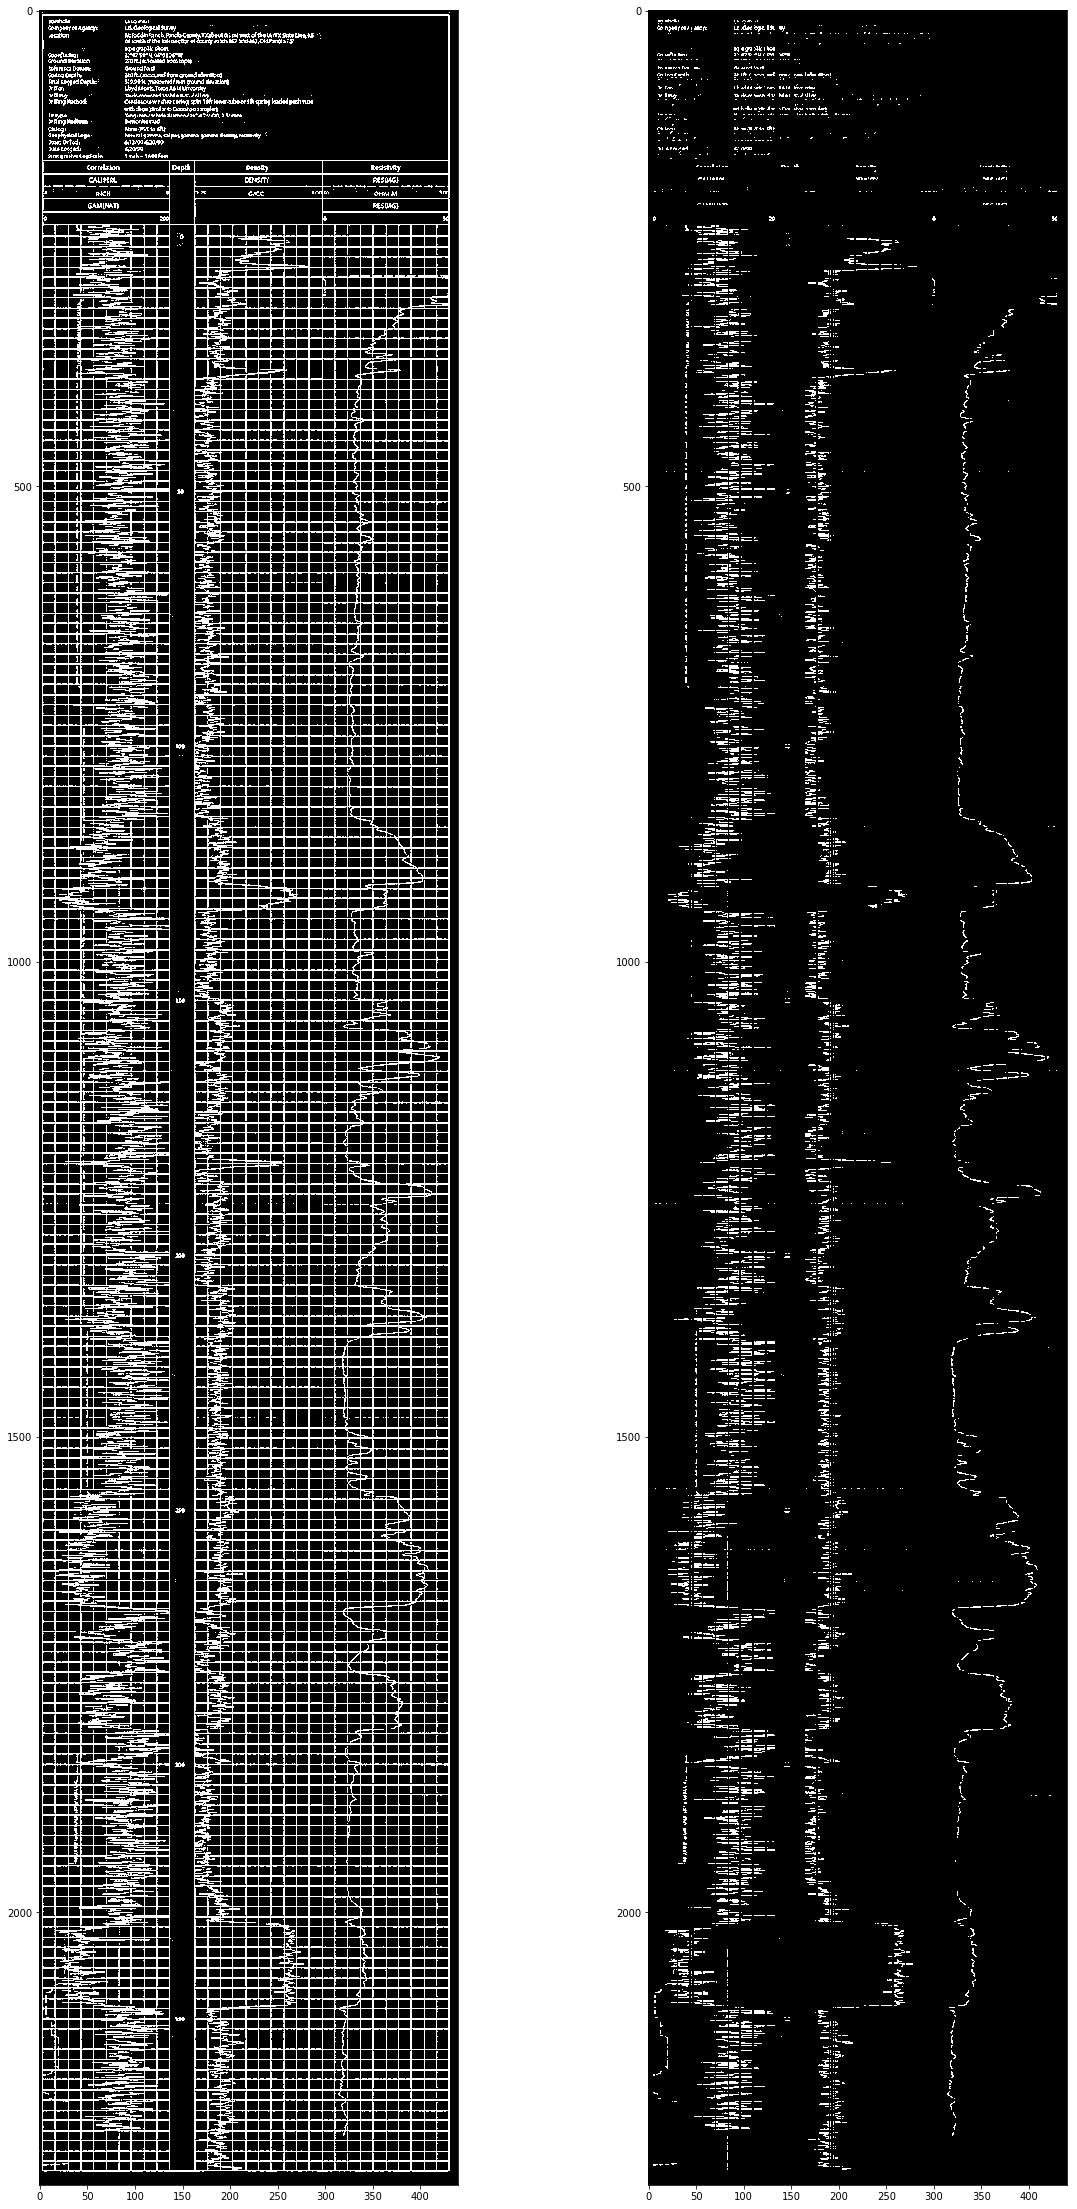

In [23]:
new2 = bw * vertKeepInterp_mask
new2 = new2.T * horzKeepInterp_mask

plt.figure(figsize=(20,40))

_ = plt.subplot(1,2,1)
_ = plt.imshow(bw, cmap='gray')

_ = plt.subplot(1,2,2)
_ = plt.imshow(new2.T, cmap='gray')

### Morph

<Figure size 1440x2880 with 0 Axes>

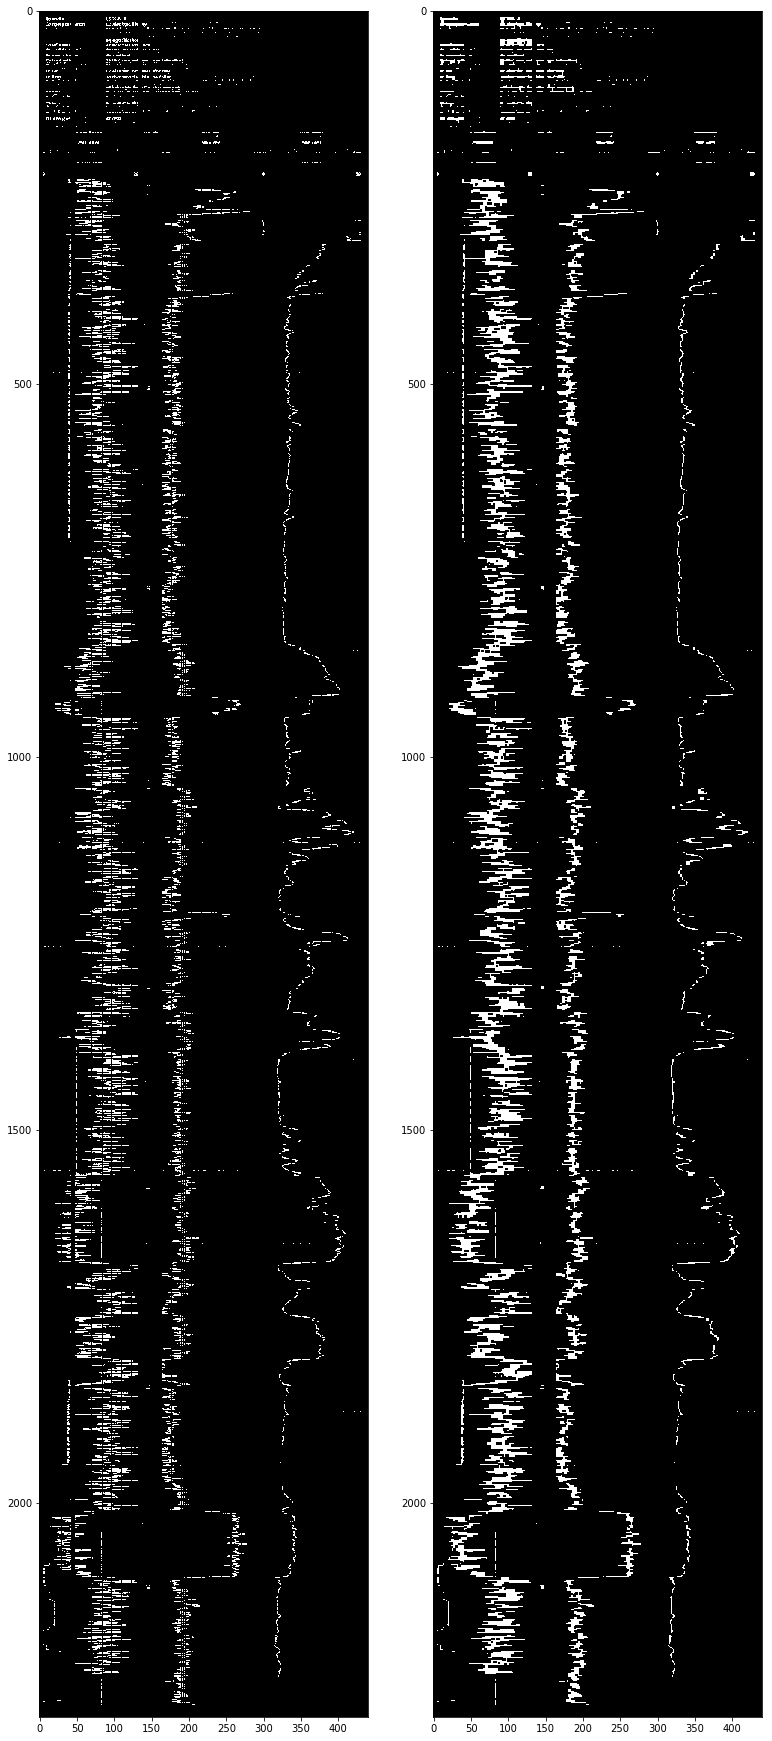

In [26]:
new3 = np.copy(new2.T)

kernel = np.ones((3,3),np.uint8)

plt.figure(figsize=(20,40))

_ = plt.subplot(1,3,1)
_ = plt.imshow(new3, cmap='gray')

new3 = cv2.dilate(new3, kernel, iterations=1)
new3 = cv2.erode(new3, kernel, iterations=1)

_ = plt.subplot(1,3,2)
_ = plt.imshow(new3, cmap='gray')
